In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from joblib import Parallel, delayed
from statsmodels.api import qqplot

In [2]:
def report(res, truth=0): # performance report from a dump of results from an estimator
    point = res[:, 0]
    stderr = res[:, 1]
    ci = (point - 1.96*stderr, point + 1.96*stderr)
    bias = np.mean(point) - truth
    rmse = np.sqrt(np.mean((point - truth)**2))
    coverage = np.mean((ci[0] <= truth) & (ci[1] >= truth))
    plt.title(f"Bias: {bias:.3f}, Coverage: {coverage:.2f}, RMSE: {rmse:.3f}")
    plt.hist(point)
    plt.show()
    qqplot((point - truth) / np.std(point), line='45')
    plt.show()
    qqplot((point - np.mean(point)) / np.std(point), line='45')
    plt.show()

In [3]:
def gen_data(n, p, truth=0): # simple dgp
    X = np.random.normal(0, 1, size=(n, p))
    D = np.random.binomial(1, .5 + np.clip(X[:, 0], -.4, .4))
    y = truth * D + X[:, 0] + X[:, 1] + np.random.normal(0, 1, size=(n,))
    return X, D, y

In [4]:
n = 1000
p = 20
truth = 0

In [5]:
def est(X, D, y): # direct non-orthogonal estimator of average effect
    est = RandomForestRegressor(min_samples_leaf=20)
    est.fit(np.hstack([D.reshape(-1, 1), X]), y)
    ones = np.hstack([np.ones((X.shape[0], 1)), X])
    zeros = np.hstack([np.zeros((X.shape[0], 1)), X])
    effects = est.predict(ones) - est.predict(zeros)
    return np.mean(effects), np.std(effects)/np.sqrt(X.shape[0])

In [6]:
np.random.seed(123)
res = Parallel(n_jobs=-1, verbose=3)(delayed(est)(*gen_data(n, p, truth)) for _ in range(100))
res = np.array(res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   51.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.3s finished


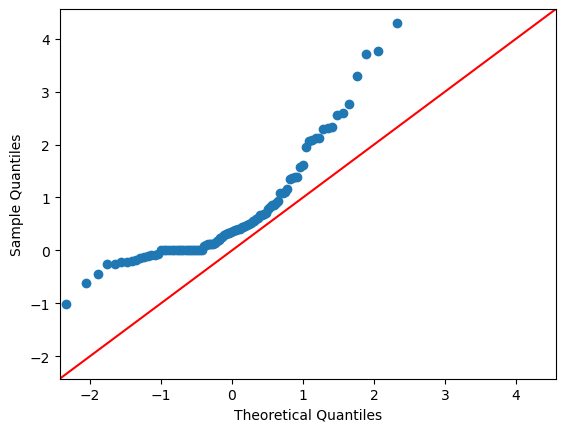

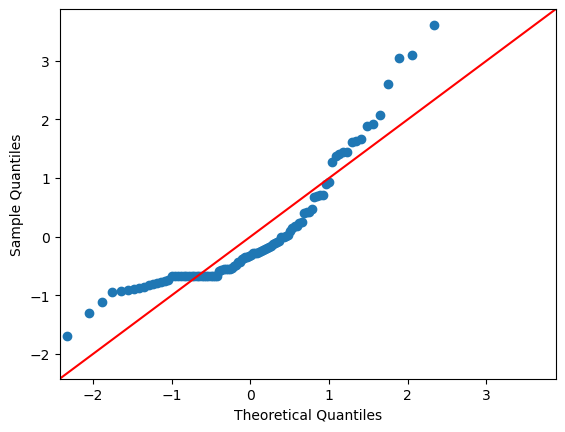

In [7]:
report(res, truth=truth)

In [8]:
def est2(X, D, y): # direct non-orthogonal estimator with sample splitting
    effects = np.zeros(X.shape[0])
    for train, test in KFold(n_splits=3).split(X):
        est = RandomForestRegressor(min_samples_leaf=20)
        est.fit(np.hstack([D[train].reshape(-1, 1), X[train]]), y[train])
        ones = np.hstack([np.ones((X[test].shape[0], 1)), X[test]])
        zeros = np.hstack([np.zeros((X[test].shape[0], 1)), X[test]])
        effects[test] = est.predict(ones) - est.predict(zeros)
    return np.mean(effects), np.std(effects)/np.sqrt(X.shape[0])

In [9]:
np.random.seed(123)
res2 = Parallel(n_jobs=-1, verbose=3)(delayed(est2)(*gen_data(n, p, truth)) for _ in range(100))
res2 = np.array(res2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   34.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.0s finished


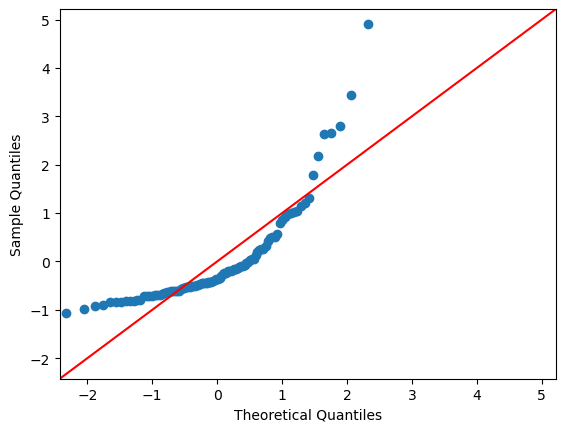

In [10]:
report(res2, truth=truth)

In [11]:
def dml(X, D, y): # debiased ml without sample-splitting
    est = RandomForestRegressor(min_samples_leaf=20)
    est.fit(np.hstack([D.reshape(-1, 1), X]), y)
    ones = np.hstack([np.ones((X.shape[0], 1)), X])
    zeros = np.hstack([np.zeros((X.shape[0], 1)), X])
    effects = est.predict(ones) - est.predict(zeros)
    clf = RandomForestClassifier(min_samples_leaf=20)
    clf.fit(X, D)
    prop = clf.predict_proba(X)[:, 1]
    riesz = (D - prop) / (prop * (1 - prop))
    effects += riesz * (y - est.predict(np.hstack([D.reshape(-1, 1), X])))
    return np.mean(effects), np.std(effects)/np.sqrt(X.shape[0])

In [12]:
np.random.seed(123)
res_dml = Parallel(n_jobs=-1, verbose=3)(delayed(dml)(*gen_data(n, p, truth)) for _ in range(100))
res_dml = np.array(res_dml)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   26.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.3s finished


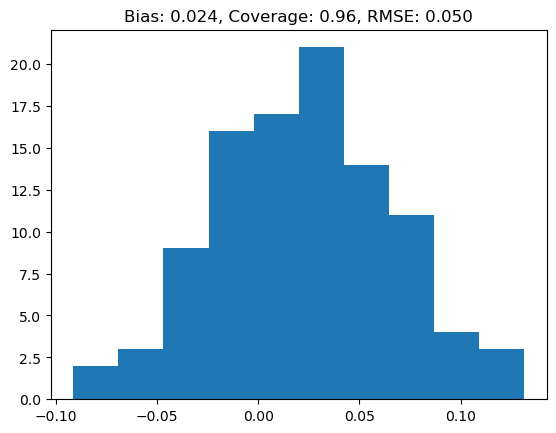

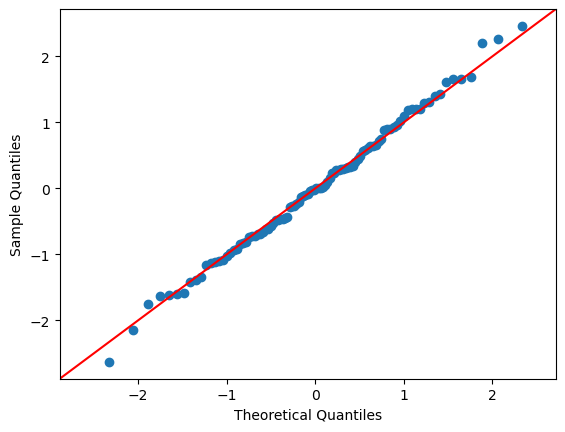

In [13]:
report(res_dml)

In [14]:
def dml2(X, D, y): # debiased ml with sample splitting
    effects = np.zeros(X.shape[0])

    for train, test in KFold(n_splits=3).split(X):
        est = RandomForestRegressor(min_samples_leaf=20)
        est.fit(np.hstack([D[train].reshape(-1, 1), X[train]]), y[train])
        ones = np.hstack([np.ones((X[test].shape[0], 1)), X[test]])
        zeros = np.hstack([np.zeros((X[test].shape[0], 1)), X[test]])
        effects[test] = est.predict(ones) - est.predict(zeros)
        
        regs = est.predict(np.hstack([D[test].reshape(-1, 1), X[test]]))
        clf = RandomForestClassifier(min_samples_leaf=20)
        clf.fit(X[train], D[train])
        prop = clf.predict_proba(X[test])[:, 1]
        riesz = (D[test] - prop) / (prop * (1 - prop))
        effects[test] += riesz * (y[test] - regs)

    return np.mean(effects), np.std(effects)/np.sqrt(X.shape[0])

In [15]:
np.random.seed(123)
res_dml2 = Parallel(n_jobs=-1, verbose=3)(delayed(dml2)(*gen_data(n, p, truth)) for _ in range(100))
res_dml2 = np.array(res_dml2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   50.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.5s finished


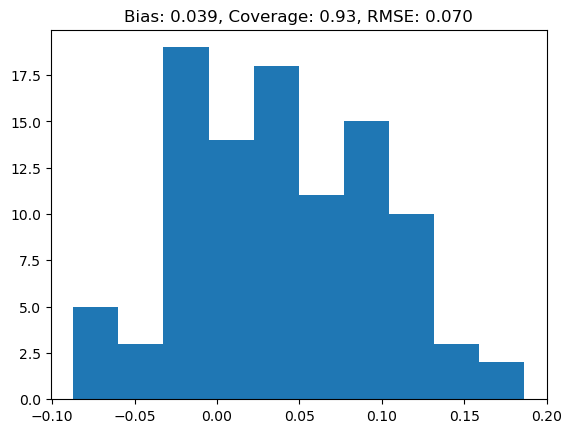

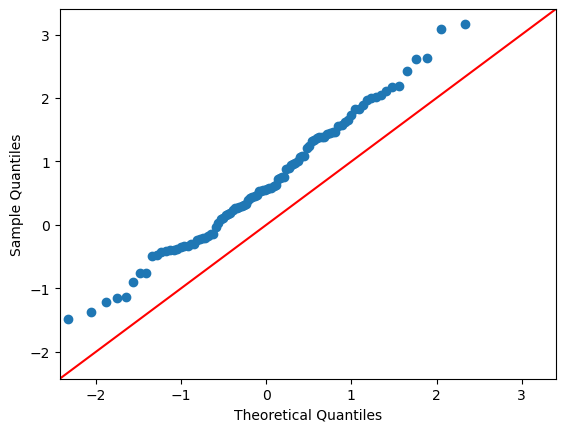

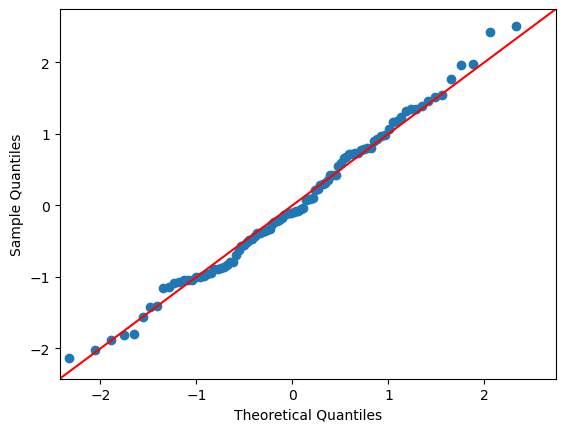

In [16]:
report(res_dml2)

In [17]:
from rfriesz import RFrr, poly_feature_fns

def moment_fn(x, test_fn):
    t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
    t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

RFrr_opt = {
    'riesz_feature_fns': poly_feature_fns(1),
    'moment_fn': moment_fn, 
    'l2': 0.,
    'criterion': 'mse', 
    'n_estimators': 100,
    'min_samples_leaf': 2,
    'min_var_fraction_leaf': 0.001, 
    'min_var_leaf_on_val': True,
    'min_impurity_decrease': 0.01, 
    'max_samples': .8, 
    'max_depth': None,
    'warm_start': False,
    'inference': False,
    'subforest_size': 1,
    'honest': True,
    'verbose': 0,
    'n_jobs': -1,
    'random_state': 123
}

In [18]:
def dml3(X, D, y): # debiased ml with sample splitting
    effects = np.zeros(X.shape[0])

    for train, test in KFold(n_splits=3).split(X):
        est = RandomForestRegressor(min_samples_leaf=20)
        est.fit(np.hstack([D[train].reshape(-1, 1), X[train]]), y[train])
        ones = np.hstack([np.ones((X[test].shape[0], 1)), X[test]])
        zeros = np.hstack([np.zeros((X[test].shape[0], 1)), X[test]])
        effects[test] = est.predict(ones) - est.predict(zeros)

        regs = est.predict(np.hstack([D[test].reshape(-1, 1), X[test]]))
        rr = RFrr(**RFrr_opt)
        rr.fit(X[train], D[train], y[train])
        riesz = rr.predict_riesz(np.hstack([D[test].reshape(-1, 1), X[test]])).flatten()
        effects[test] += riesz * (y[test] - regs)

    return np.mean(effects), np.std(effects)/np.sqrt(X.shape[0])

In [19]:
np.random.seed(123)
res_dml3 = Parallel(n_jobs=-1, verbose=3)(delayed(dml3)(*gen_data(n, p, truth)) for _ in range(100))
res_dml3 = np.array(res_dml3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:  1.6min remaining:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


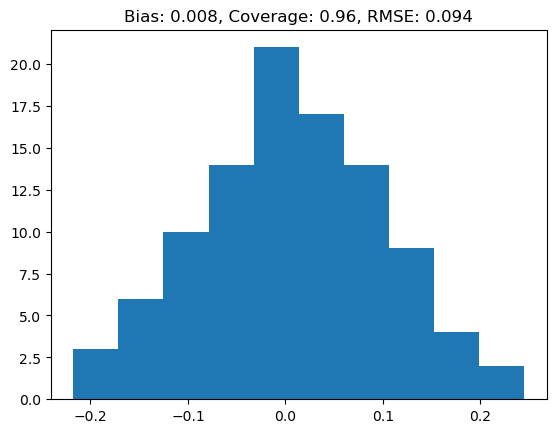

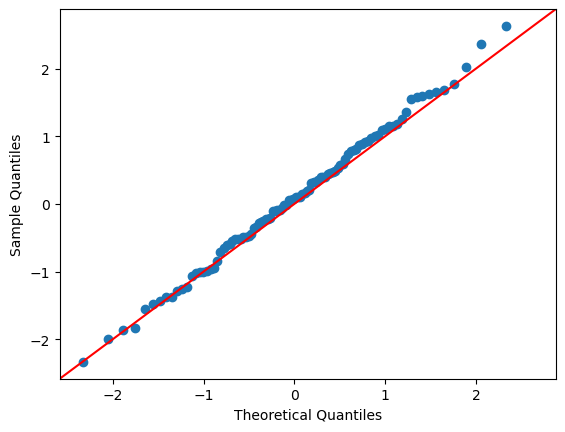

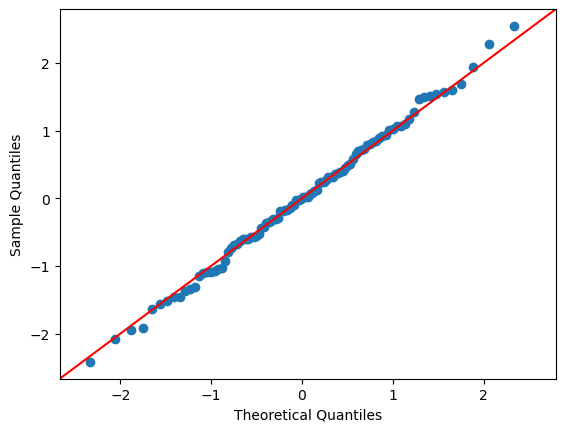

In [20]:
report(res_dml3)